# Final Project Part 2: Comparison of Approaches
## Travis Hammond - s2880024

First, let's import the basics. This is the same code as in previous Homeworks, except that an option to disable noise is added to the time_to_pulses and pulses_to_time functions.

In [1]:
from pathlib import Path
import sys; sys.path.append(Path().resolve().parent.as_posix())  # noqa

from ACTR.model import Model
from ACTR.dmchunk import Chunk

import matplotlib.pyplot as plt
from scipy.stats import rv_discrete
import pandas as pd
import numpy as np

rng = np.random.default_rng(seed=111)


def noise(s: float) -> float:
    rand = rng.uniform(0.001, 0.999)
    return s * np.log((1 - rand) / rand)


def time_to_pulses(
            time: float,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015,
            add_noise: bool = True,
        ) -> int:
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        noise_component = noise(b * a * pulse_duration) if add_noise else 0
        pulse_duration = a * pulse_duration + noise_component
    return pulses


def pulses_to_time(
            pulses: int,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015,
            add_noise: bool = True,
        ) -> float:
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        noise_component = noise(b * a * pulse_duration) if add_noise else 0
        pulse_duration = a * pulse_duration + noise_component
    return time

The get_error and do_trial functions remain untouched and are simply repeated here:

In [2]:
def get_error(interval, response, k=400, err_type='skewed'):
    # Get the error / feedback in different forms
    return {
        'skewed':     k * ((response - interval) / response),
        'fractional': k * ((response - interval) / interval),
        'standard':   k * (response - interval),
    }[err_type]


def do_trial(subj: Model, distribution) -> float:
    # Participants click the mouse after a time of their choosing to start
    # Time of their choosing is interpreted here as a uniform time in 0.5-3s
    subj.time += sum(rng.uniform(0.500, 3.000, size=1))  # click

    # x ms delay (sampled from distribution), then the yellow dot was flashed
    sample_interval = distribution.rvs(1) / 1000
    subj.time += sample_interval  # flash

    # Take the same model as in the previous homeworks as a baseline
    # Convert time to pulses and remember how many it took
    counted_pulses = time_to_pulses(sample_interval)
    subj.add_encounter(Chunk(
        name=f'pf_{counted_pulses}',
        slots={'isa': 'pulse-fact', 'pulses': counted_pulses}
    ))

    # Flash is shown for 18.5ms
    subj.time += 0.0185  # end flash

    # Retrieve a blended trace
    request = Chunk(
        name='pulse-request',
        slots={'isa': 'pulse-fact'}
    )
    estimated_pulses, _ = subj.retrieve_blended_trace(request, 'pulses')
    # Convert pulses back to time
    response_interval = pulses_to_time(estimated_pulses)

    # Subjects were required to wait at least 250ms before reproducing.
    # 'at least' is interpreted here as a uniform distribution from 250-350ms
    # TODO: i guess it would actually be more skewed towards 250ms and truncated
    subj.time += sum(rng.uniform(0.250, 0.350, size=1))  # end wait

    # Interval is estimated and reproduced by holding the mouse click
    subj.time += response_interval  # release mouse click

    # Feedback is represented after a uniformly sampled delay (450-850ms)
    subj.time += sum(rng.uniform(0.450, 0.850, size=1))  # end delay

    # Feedback is presented for 62ms
    error = get_error(sample_interval, response_interval)
    subj.time += 0.062  # end feedback

    # Fixation cross disappears after 500-750ms, followed by a blank screen for
    # another 500-750ms and then the trial restarts. interpreted as uniform.
    subj.time += sum(rng.uniform(0.500, 0.750, size=2))

    return sample_interval, response_interval, error


The plotting functions are changed, however, to produce a similar set of plots to Figure 7 of Acerbi et al. (2012). See below for more details on the plotting code.

In [3]:
def subplot_prior(ax, data: pd.DataFrame) -> None:
    for dist_val, dist_group in data.groupby('distribution'):
        items = []
        for time_val, time_group in dist_group.groupby('time_estimation'):
            items.append((
                time_val,
                time_group['activation'].mean(),
                time_group['activation'].std(),
            ))

        pulses, means, stds = [
            np.array(sublist) for sublist in list(zip(*sorted(items)))
        ]

        color = 'C0' if dist_val in ['short', 'medium'] else 'C1'
        ax.plot(pulses, means, label=dist_val, color=color)
        ax.fill_between(pulses, means+stds, means-stds, alpha=0.5, color=color)


def plot(spec: dict, data: pd.DataFrame) -> None:
    # Consider a single randomly chosen subject
    single = data[data['subject'] == rng.choice(pd.unique(data['subject']))]

    # Create subplots
    fig, axs = plt.subplots(
        nrows=2, ncols=2, sharex=True, figsize=(15, 7),
        gridspec_kw={'height_ratios': [5, 1]}
    )
    ((ssubj, group), (h1, h2)) = axs
    fig.subplots_adjust(hspace=0.0)

    # Get distributions and create top row histograms
    dist1, dist2 = spec['blocks']
    xticks = np.unique(np.concatenate((dist1.xk, dist2.xk)))
    # Make sure the peaked dist goes on top, and the shorter dist below
    if not all(dist1.pk == dist1.pk[0]) or dist1.xk[0] > dist2.xk[0]:
        (dist1, dist2) = (dist2, dist1)
    for hist in [h1, h2]:
        hist.bar(dist1.xk, dist1.pk, width=20)
        hist.bar(dist2.xk, dist2.pk, width=20, bottom=dist1.pk + 0.2)
        hist.set_xticks(xticks)
        hist.set_yticks([])
        hist.set_xlabel('Physical time interval (ms)')

    # Populate the rest of the plots
    subplot_prior(ssubj, single)
    ssubj.set_title('Single subject')
    ssubj.set_ylabel('Activation / Prior')

    subplot_prior(group, data)
    group.set_title('Group mean')
    group.text(
        0.8, 0.1, 'n = {}'.format(spec['n_subj']),
        transform=group.transAxes
    )

    [ax.set_xticks(xticks) for ax in (h1, h2)]
    [ax.set_xlim(min(xticks) - 200, max(xticks) + 200) for ax in axs.flatten()]
    fig.suptitle(spec['name'])

Now in the experiment loop, I make only a slight modification in which after every trial throughout the experiment I iterate over the declarative memory and record the activation values of each chunk that was encountered during the current block. These activation values at each point in time represent our prior, because they directly reflect the probabilities of each memory being retrieved.

To do this, I use the get_activation method of the ACT-R model instead of the get_activation_no_noise method, because that noise would be applied on any actual retrieval attempt so removing that noise component would in fact result in a less accurate reflection of the retrieval probabilities. When converting the pulses to time in milliseconds, however, I disable the noise component because as we are just plotting the state of the prior (and not modeling a behaviour) there is no need to model any noise in the conversion.

I collect the activations of each chunk in the DM at each iteration, so then in the plotting code listed above I can compute the mean activation and the corresponding standard deviation of each chunk throughout the experiment. Using these values I can draw a shaded region of +- 1 std above and below the mean activations.

I also experimented with converting the mean activations into probability densities by means of a softmax operation, but I was unsure how that operation translates to the variance so I left it out. The following code did not produce a satisfactory plot:

    probs = np.exp(means) / np.sum(np.exp(means))  # softmax
    ratios = probs / means  # scale stds on a per-point ratio basis
    scaled_stds = stds * ratios

And neither did this code:

    probs = means / np.sum(means)
    ratios = probs / means
    scaled_stds = stds * ratios


In [4]:
def do_experiment(spec: dict) -> pd.DataFrame:
    data = list()
    acts = list()

    # Subject loop
    for subj_id, subj in [(id, Model()) for id in range(spec['n_subj'])]:

        # Block loop
        rng.shuffle(spec['blocks'])
        for distribution in spec['blocks']:
            t_block = subj.time

            # Session / Trial loops (2 training sessions, 2 testing sessions)
            for sess_idx in range(4):
                # Session are fixed at 500 Trials to simplify things
                for trial_idx in range(500):

                    # Do trial
                    interval, response, error = do_trial(subj, distribution)

                    # Collect data (ignore training sessions)
                    if sess_idx < 2: continue
                    data.append([
                        interval, response, error,
                        distribution.name, subj_id,
                        sess_idx, trial_idx
                    ])

                    # Collect activation data
                    for chunk in subj.dm:
                        # Only check pulse-fact chunks, and chunks encountered
                        # within the last block
                        recent = any([t > t_block for t in chunk.encounters])
                        if 'pulses' not in chunk.slots or not recent:
                            continue

                        pulses = chunk.slots['pulses']
                        acts.append([
                            distribution.name, subj_id,
                            pulses_to_time(pulses, add_noise=False) * 1000,
                            subj.get_activation(chunk)
                        ])

                # Between session break
                subj.time += 30

            # Between block break
            subj.time += 60

    return (pd.DataFrame(data=data, columns=[
        'interval', 'response', 'feedback',
        'distribution', 'subject',
        'session_idx', 'trial_idx',
    ]), pd.DataFrame(data=acts, columns=[
        'distribution', 'subject',
        'time_estimation', 'activation',
    ]))


# Define Experiment1
exp1 = {
    'name': 'Experiment 1',
    'n_subj': 4,
    'blocks': np.array([
        rv_discrete(name='short', seed=rng, values=(
                np.linspace(start=450, stop=825, num=6),
                np.repeat(1/6, 6),
            ),
        ),
        rv_discrete(name='long', seed=rng, values=(
                np.linspace(start=750, stop=1125, num=6),
                np.repeat(1/6, 6),
            ),
        ),
    ])
}

# Define Experiment2
exp2 = {
    'name': 'Experiment 2',
    'n_subj': 6,
    'blocks': np.array([
        rv_discrete(name='medium', seed=rng, values=(
                np.linspace(start=600, stop=975, num=6),
                np.repeat(1/6, 6),
            ),
        ),
        rv_discrete(name='medium_peaked', seed=rng, values=(
                np.linspace(start=600, stop=975, num=6),
                np.array([1/12, 7/12, 1/12, 1/12, 1/12, 1/12]),
            ),
        ),
    ])
}

Let's see how the plots look like:

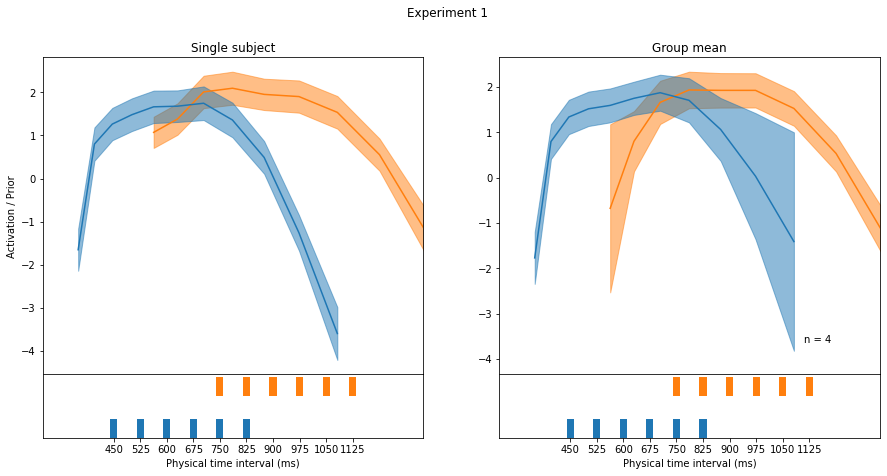

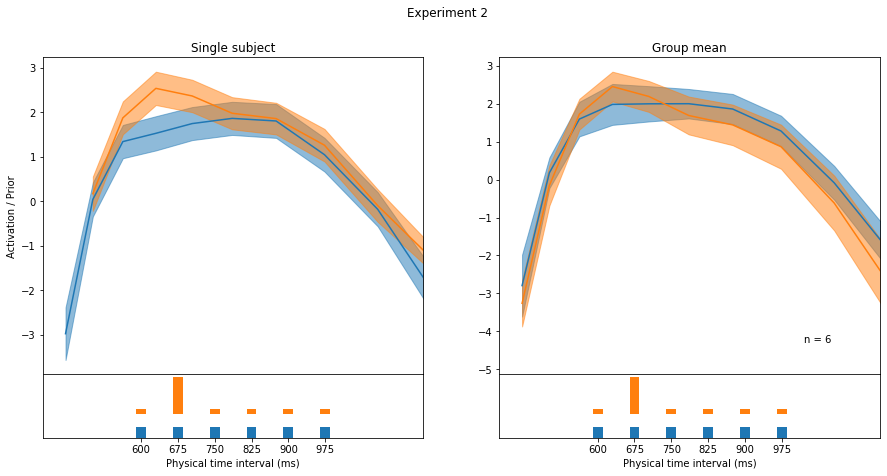

In [5]:
plot(exp1, do_experiment(exp1)[1])
plot(exp2, do_experiment(exp2)[1])

### (a) Are there qualitative differences between the two figures? If so, what may be the cause of these differences?

We can immediately see one qualitative difference between our plots and the plots in Figure 7 of Acerbi et al. (2012), and that is the rough shape of the prior over the time interval. In our plots, the shape of the distributions roughly resemble a (flipped) parabola while in Figure 7 they look more like the (multimodal) bell shaped curve typical for probability distributions. This could be due to the fact that we are plotting the activations of the chunks which, while very similar, is not exactly the same as a probability density distribution over the prior.

Upon closer inspection, we can also see many qualitative similarities. For example, the group averages for the Uniform priors (top right, both curves, bottom right, blue curve) are all very similar, apart from a simple shift on the x-axis, just like in Figure 7. In fact, even the single subject Uniform priors are similar.

Another similarity is that the prior for the peaked distribution does indeed peak at the time interval which has the highest probability, and seems to slightly influence the Uniform prior at that point. This can be seen in the group mean plot on the bottom right, which averages away the difference between block orderings, where the blue curve is closer to the peaked curve at 675ms than in the single subject plot on the bottom left.

The increase in variance in the top right plot for both curves on the inward facing tail is due to the fact that the block order during the experiment is randomized, and the second block will start with "primed" chunks in declarative memory for the overlapping intervals. This effect can be seen in the single subject plot on the top left, where orange ('long') was the second block and the activations for the left tail of the long distribution is higher than the right tail of the short distribution.

### (b) At a more theoretical level, how does your model’s DM compare to the priors that Acerbi derived from participants’ responses?

The main difference between our model and the model in Acerbi et al. (2012) is that theirs is a Bayesian model, while ours is an ACT-R model. Because we directly model the declarative memory, this allows us to directly plot the state of the prior instead of having to reconstruct the priors like Acerbi et al. do in their paper. There are more, deeper reaching differences between these styles of modelling, such as the level of abstraction. Using ACT-R, we aim for a more precise model of the inner cognitive workings while Bayesian models are more mathematical and theoretical. For example, we model the declarative memory in terms of actual chunks of memory and their activations, the decay of those activations, the noise related to their retrieval, and many more details in a very imperative way. We describe at each point precisely what happens. In the Bayesian approach, many of the details are abstracted away and replaced by a simpler mathematical model. This is not better or worse, but comes with its own pros and cons such as having a cleaner, more abstract but still informative model about which can be reasoned mathematically, at the expense of losing information about the details and inner workings of the cognitive process, and having a less flexible model.
